#tesnorflow install

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#!pip install tensorflow
import tensorflow as tf
tf.__version__

'2.15.0'

#import libraries

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import InceptionResNetV2
import matplotlib.pyplot as plt


#define size and epoch

In [31]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
CHANNELS =3
EPOCHS = 10

#import dataset

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/rice_img',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4347 files belonging to 3 classes.


#get classnames and images per batch

In [32]:
class_names=dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Tungro']

In [8]:
len(dataset)


68

#plot figures

(64, 224, 224, 3)
[0 1 0 1 1 0 0 1 2 1 0 1 0 2 2 0 0 0 0 2 1 2 1 2 1 1 0 0 0 0 0 2 2 1 2 2 0
 0 0 0 2 0 1 1 2 2 2 0 0 1 0 1 0 1 2 0 0 0 2 1 0 1 2 1]


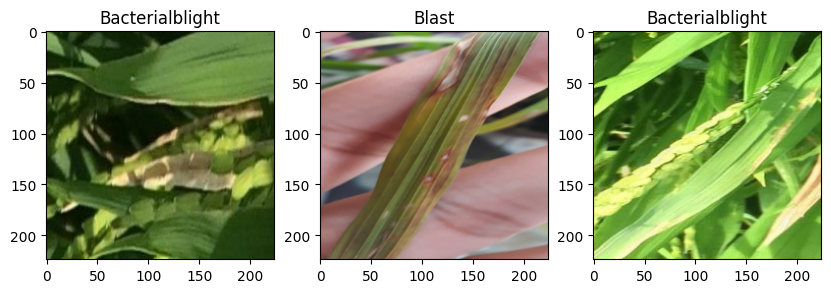

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):

    #show batch size,image size,rgb channel
    print(image_batch.shape)

    #show classes
    print(label_batch.numpy())

    #show image of the first data
    for i in range(3):
        ax=plt.subplot(1,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

#dataset split

In [33]:
def dataset_split_tf(ds, train_split=0.75, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds



#Shuffle dataset

In [34]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

AttributeError: 'str' object has no attribute 'cache'

#import IceptionResnetV2

In [35]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


In [36]:
base_model.trainable = False

In [37]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

#model train

In [38]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=(None,) + input_shape)

#model summary

In [39]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 512)               786944    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

#compile model

In [40]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#train model

In [41]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

IndexError: tuple index out of range

#get accuracy

In [20]:
scores = model.evaluate(test_ds)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

7/7 [==============================] - 17s 295ms/step - loss: 0.0042 - accuracy: 1.0000
Test Loss: 0.004212527070194483
Test Accuracy: 1.0


#parameters

In [21]:
history.params
history.history.keys()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot training accuracy and loss

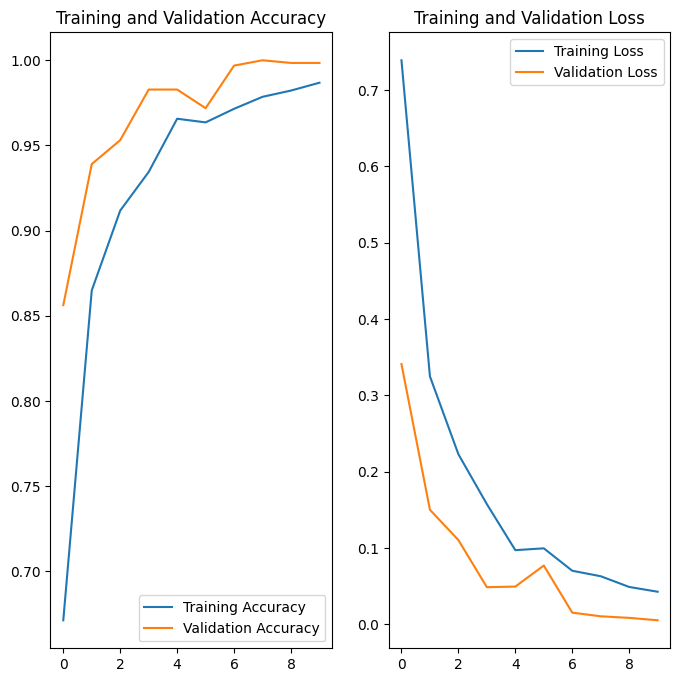

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#prediction

import numpy as np
for images_batch, label_batch in test_ds.take(1):

    first_image=images_batch[0].numpy().astype('uint8')
    first_label=label_batch[0]

    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label:",class_names [first_label])
    batch_prediction=model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])] )#will show three nueron n_classes parameters


#prediction function

In [23]:
def prediction(model,img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    #create a batch
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

#plot actual and prediction

1/1 [==============================] - 0s 37ms/step


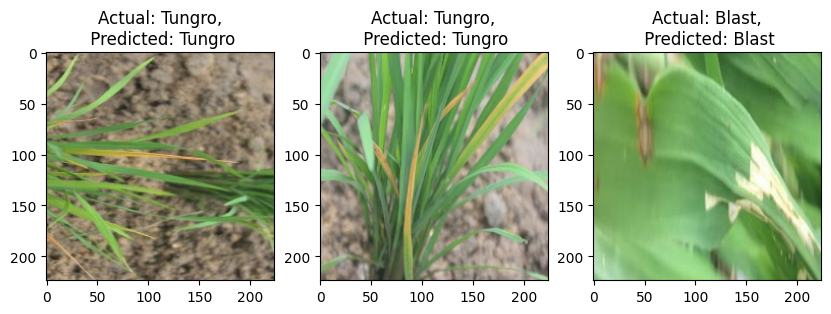

In [24]:
import numpy as np
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = prediction(model, images[i])
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}")

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Evaluation Metrics
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

2/2 [==============================] - 0s 153ms/step
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
